In [28]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score 
import optuna


In [29]:
xgb = XGBClassifier(objective="binary:logistic",  # klasyfikacja binarna
    eval_metric="logloss",        # metryka logloss
    tree_method="hist",           # szybka metoda histogramowa
    booster="gbtree",             # klasyczny booster
    random_state=42,
    n_jobs=-1
)

baseline_xgb = XGBClassifier(
    objective="binary:logistic", eval_metric="logloss",
    tree_method="hist", n_jobs=-1, random_state=42
)

In [30]:
RS_param_grid = {
    "n_estimators": [300, 600, 900, 1200],
    "max_depth": [3, 4, 6, 8],
    "learning_rate": [0.01, 0.03, 0.1],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 2, 5, 8],
    "gamma": [0.0, 1.0, 3.0],
    "reg_lambda": [0.0, 1.0, 5.0, 10.0],
    "reg_alpha": [0.0, 0.1, 1.0, 5.0],
    "scale_pos_weight": [1.0, 2.0, 5.0],
    "colsample_bylevel": [0.6, 0.8, 1.0],
    "grow_policy": ["depthwise", "lossguide"],
    "max_bin": [256, 512],
    "max_leaves": [15, 31, 63]
}

In [31]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=RS_param_grid,
    n_iter=50,  
    cv=3,  #
    scoring='roc_auc', 
    verbose=1,
    random_state=42,
    n_jobs=-1 
)

In [ ]:
from skopt.space import Real, Integer, Categorical

BS_param_grid = {
    "n_estimators": Integer(300, 1200),
    "max_depth": Integer(3, 8),
    "learning_rate": Real(0.01, 0.1, prior="log-uniform"),
    "subsample": Real(0.6, 1.0),
    "colsample_bytree": Real(0.6, 1.0),
    "min_child_weight": Integer(1, 8),
    "gamma": Real(0.0, 3.0),
    "reg_lambda": Real(0.0, 10.0),
    "reg_alpha": Real(0.0, 5.0),
    "scale_pos_weight": Real(1.0, 5.0)
}

In [33]:
from skopt import BayesSearchCV
bayes = BayesSearchCV(
    estimator=xgb,
    search_spaces=BS_param_grid,
    n_iter=60,                
    cv=5,
    scoring="roc_auc",      
    n_jobs=-1,
    random_state=42,
    refit=True,
    verbose=0,
)

# DIABETES

In [34]:
df_diabetes = pd.read_csv("diabetes_transformed.csv")   

X = df_diabetes.drop('diabetes', axis=1)  
y = df_diabetes['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from sklearn.metrics import roc_auc_score

baseline_xgb.fit(X_train, y_train)

y_score_base = baseline_xgb.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)

print(f"Baseline XGB (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

Baseline XGB (bez tuningu) – Test ROC AUC: 0.9799


## RANDOMIZED SEARCH

In [36]:
random_search.fit(X_train, y_train)

results = random_search.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search.best_params_

print("Najlepsze parametry:", best_params_random)

diab_random = pd.DataFrame(results).copy()
diab_random["method"] = "random"
diab_random["iter"] = np.arange(len(diab_random))
diab_random["running_best"] = np.maximum.accumulate(diab_random["mean_test_score"])

# ROC AUC
y_score_rs = random_search.predict_proba(X_test)[:, 1] 
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Najlepsze parametry: {'subsample': 0.8, 'scale_pos_weight': 5.0, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'n_estimators': 600, 'min_child_weight': 2, 'max_leaves': 63, 'max_depth': 4, 'max_bin': 256, 'learning_rate': 0.03, 'grow_policy': 'depthwise', 'gamma': 1.0, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.8}
RandomSearch – CV mean(best) ROC AUC: 0.9797
RandomSearch – Test ROC AUC: 0.9828
RandomSearch – Liczba iteracji: 50


## BAYES SEARCH

In [37]:
bayes.fit(X_train, y_train)

print("Najlepsze parametry:", bayes.best_params_)

diab_bayes = pd.DataFrame(bayes.cv_results_).copy()
diab_bayes["method"] = "bayes"
diab_bayes["iter"] = np.arange(len(diab_bayes))
diab_bayes["running_best"] = np.maximum.accumulate(diab_bayes["mean_test_score"])

# ROC AUC
y_score_bayes = bayes.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(diab_bayes)}")

Najlepsze parametry: OrderedDict({'colsample_bytree': 0.6, 'gamma': 1.6849388965808147, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 1090, 'reg_alpha': 1.839039283848498, 'reg_lambda': 0.0, 'scale_pos_weight': 2.784790237586658, 'subsample': 1.0})
BayesSearch – CV mean(best) ROC AUC: 0.9799
BayesSearch – Test ROC AUC: 0.9827
BayesSearch – Liczba iteracji: 60


## WYKRESY

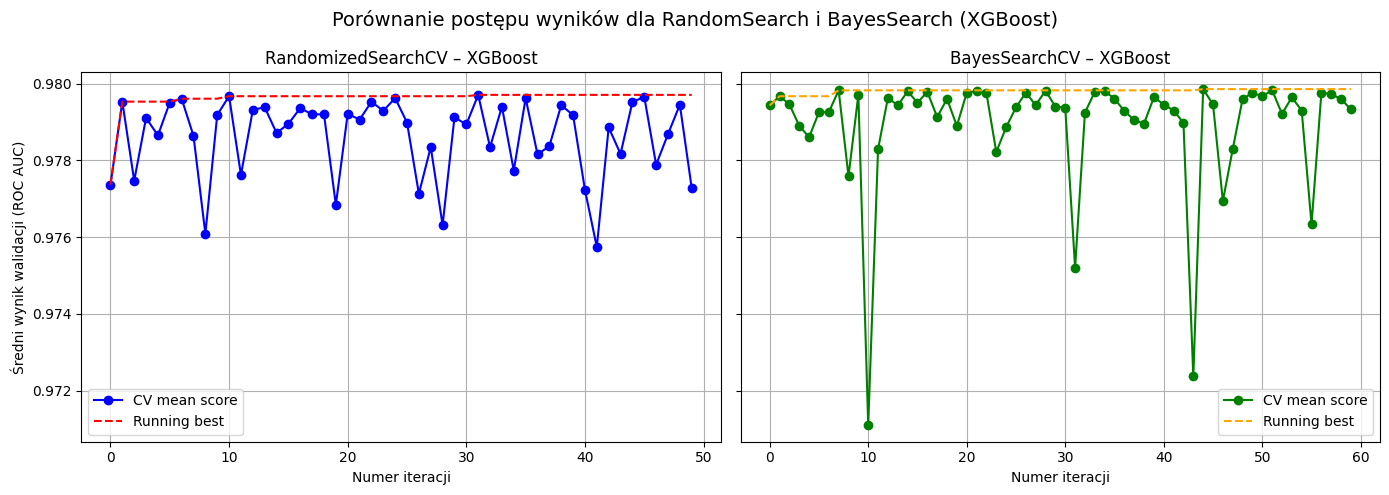

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(diab_random["iter"], diab_random["mean_test_score"], marker="o", label="CV mean score", color="blue")
axes[0].plot(diab_random["iter"], diab_random["running_best"], color="red", linestyle="--", label="Running best")
axes[0].set_title("RandomizedSearchCV – XGBoost")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(diab_bayes["iter"], diab_bayes["mean_test_score"], marker="o", label="CV mean score", color="green")
axes[1].plot(diab_bayes["iter"], diab_bayes["running_best"], color="orange", linestyle="--", label="Running best")
axes[1].set_title("BayesSearchCV – XGBoost")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (XGBoost)", fontsize=14)
plt.tight_layout()
plt.show()


# LOAN

In [39]:
df_loan = pd.read_csv("loan_transformed.csv")   

X = df_loan.drop('charged_off', axis=1)  
y = df_loan['charged_off']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
from sklearn.metrics import roc_auc_score

baseline_xgb.fit(X_train, y_train)

y_score_base = baseline_xgb.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)

print(f"Baseline XGB (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

Baseline XGB (bez tuningu) – Test ROC AUC: 0.9780


## RANDOMIZED SEARCH

In [41]:
random_search.fit(X_train, y_train)

results = random_search.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search.best_params_

print("Najlepsze parametry:", best_params_random)

loan_random = pd.DataFrame(results).copy()
loan_random["method"] = "random"
loan_random["iter"] = np.arange(len(loan_random))
loan_random["running_best"] = np.maximum.accumulate(loan_random["mean_test_score"])

# ROC AUC
y_score_rs = random_search.predict_proba(X_test)[:, 1] 
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Najlepsze parametry: {'subsample': 0.8, 'scale_pos_weight': 2.0, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'n_estimators': 900, 'min_child_weight': 5, 'max_leaves': 63, 'max_depth': 6, 'max_bin': 512, 'learning_rate': 0.03, 'grow_policy': 'depthwise', 'gamma': 3.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}
RandomSearch – CV mean(best) ROC AUC: 0.9726
RandomSearch – Test ROC AUC: 0.9816
RandomSearch – Liczba iteracji: 50


## BAYES SEARCH

In [42]:
bayes.fit(X_train, y_train)

print("Najlepsze parametry:", bayes.best_params_)

loan_bayes = pd.DataFrame(bayes.cv_results_).copy()
loan_bayes["method"] = "bayes"
loan_bayes["iter"] = np.arange(len(loan_bayes))
loan_bayes["running_best"] = np.maximum.accumulate(loan_bayes["mean_test_score"])

# ROC AUC
y_score_bayes = bayes.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(loan_bayes)}")

Najlepsze parametry: OrderedDict({'colsample_bytree': 0.8671921022874631, 'gamma': 3.0, 'learning_rate': 0.01362842822510305, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 1200, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'scale_pos_weight': 2.714062105722575, 'subsample': 0.6})
BayesSearch – CV mean(best) ROC AUC: 0.9760
BayesSearch – Test ROC AUC: 0.9821
BayesSearch – Liczba iteracji: 60


## WYKRESY

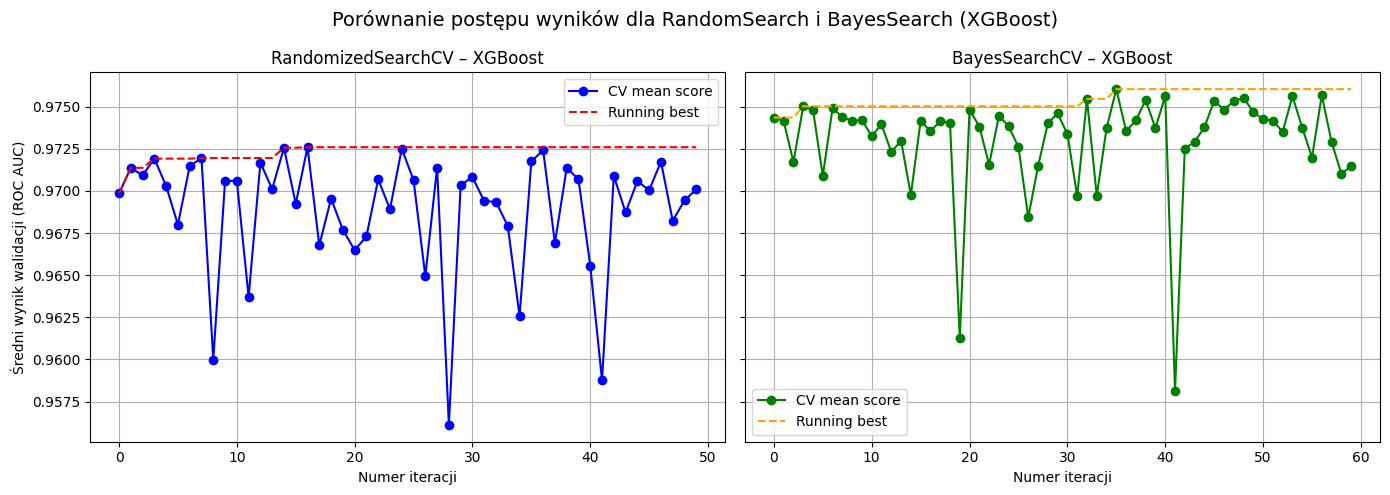

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(loan_random["iter"], loan_random["mean_test_score"], marker="o", label="CV mean score", color="blue")
axes[0].plot(loan_random["iter"], loan_random["running_best"], color="red", linestyle="--", label="Running best")
axes[0].set_title("RandomizedSearchCV – XGBoost")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(loan_bayes["iter"], loan_bayes["mean_test_score"], marker="o", label="CV mean score", color="green")
axes[1].plot(loan_bayes["iter"], loan_bayes["running_best"], color="orange", linestyle="--", label="Running best")
axes[1].set_title("BayesSearchCV – XGBoost")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (XGBoost)", fontsize=14)
plt.tight_layout()
plt.show()


# DEPRESSION

In [44]:
df_depression = pd.read_csv("depression_transformed.csv")   

X = df_depression.drop('History of Mental Illness', axis=1)  
y = df_depression['History of Mental Illness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
from sklearn.metrics import roc_auc_score

baseline_xgb.fit(X_train, y_train)

y_score_base = baseline_xgb.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)

print(f"Baseline XGB (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

Baseline XGB (bez tuningu) – Test ROC AUC: 0.5946


## RANDOMIZED SEARCH

In [46]:
random_search.fit(X_train, y_train)

results = random_search.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search.best_params_

print("Najlepsze parametry:", best_params_random)

dep_random = pd.DataFrame(results).copy()
dep_random["method"] = "random"
dep_random["iter"] = np.arange(len(dep_random))
dep_random["running_best"] = np.maximum.accumulate(dep_random["mean_test_score"])

# ROC AUC
y_score_rs = random_search.predict_proba(X_test)[:, 1] 
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Najlepsze parametry: {'subsample': 0.6, 'scale_pos_weight': 2.0, 'reg_lambda': 1.0, 'reg_alpha': 5.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_leaves': 31, 'max_depth': 3, 'max_bin': 256, 'learning_rate': 0.1, 'grow_policy': 'lossguide', 'gamma': 0.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0}
RandomSearch – CV mean(best) ROC AUC: 0.5999
RandomSearch – Test ROC AUC: 0.5993
RandomSearch – Liczba iteracji: 50


## BAYES SEARCH

In [47]:
bayes.fit(X_train, y_train)

print("Najlepsze parametry:", bayes.best_params_)

dep_bayes = pd.DataFrame(bayes.cv_results_).copy()
dep_bayes["method"] = "bayes"
dep_bayes["iter"] = np.arange(len(dep_bayes))
dep_bayes["running_best"] = np.maximum.accumulate(dep_bayes["mean_test_score"])

# ROC AUC
y_score_bayes = bayes.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(dep_bayes)}")

Najlepsze parametry: OrderedDict({'colsample_bytree': 0.7138634987479973, 'gamma': 2.221579403993632, 'learning_rate': 0.05062732465921029, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 312, 'reg_alpha': 3.063122447012031, 'reg_lambda': 8.858765011180461, 'scale_pos_weight': 2.653184058924096, 'subsample': 0.8983998448947528})
BayesSearch – CV mean(best) ROC AUC: 0.6000
BayesSearch – Test ROC AUC: 0.5999
BayesSearch – Liczba iteracji: 60


## WYKRESY


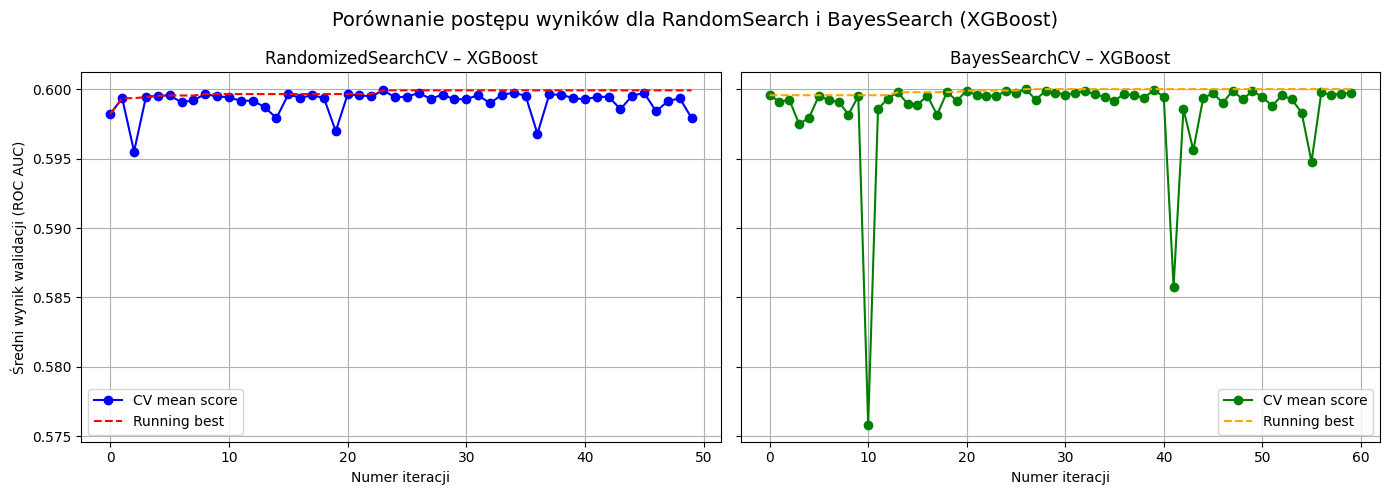

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(dep_random["iter"], dep_random["mean_test_score"], marker="o", label="CV mean score", color="blue")
axes[0].plot(dep_random["iter"], dep_random["running_best"], color="red", linestyle="--", label="Running best")
axes[0].set_title("RandomizedSearchCV – XGBoost")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(dep_bayes["iter"], dep_bayes["mean_test_score"], marker="o", label="CV mean score", color="green")
axes[1].plot(dep_bayes["iter"], dep_bayes["running_best"], color="orange", linestyle="--", label="Running best")
axes[1].set_title("BayesSearchCV – XGBoost")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (XGBoost)", fontsize=14)
plt.tight_layout()
plt.show()


# WEATHER

In [50]:
df_weather = pd.read_csv("weather_transformed.csv")   

X = df_weather.drop('RainTomorrow', axis=1)  
y = df_weather['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
from sklearn.metrics import roc_auc_score

baseline_xgb.fit(X_train, y_train)

y_score_base = baseline_xgb.predict_proba(X_test)[:, 1]
baseline_roc = roc_auc_score(y_test, y_score_base)

print(f"Baseline XGB (bez tuningu) – Test ROC AUC: {baseline_roc:.4f}")

Baseline XGB (bez tuningu) – Test ROC AUC: 0.8983


## RANDOMIZED SEARCH

In [52]:
random_search.fit(X_train, y_train)

results = random_search.cv_results_
num_iterations = len(results['params'])
best_params_random = random_search.best_params_

print("Najlepsze parametry:", best_params_random)

weather_random = pd.DataFrame(results).copy()
weather_random["method"] = "random"
weather_random["iter"] = np.arange(len(weather_random))
weather_random["running_best"] = np.maximum.accumulate(weather_random["mean_test_score"])

# ROC AUC
y_score_rs = random_search.predict_proba(X_test)[:, 1] 
test_roc_rs = roc_auc_score(y_test, y_score_rs)

print(f"RandomSearch – CV mean(best) ROC AUC: {random_search.best_score_:.4f}")
print(f"RandomSearch – Test ROC AUC: {test_roc_rs:.4f}")
print(f"RandomSearch – Liczba iteracji: {num_iterations}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Najlepsze parametry: {'subsample': 0.8, 'scale_pos_weight': 2.0, 'reg_lambda': 5.0, 'reg_alpha': 0.1, 'n_estimators': 900, 'min_child_weight': 5, 'max_leaves': 63, 'max_depth': 6, 'max_bin': 512, 'learning_rate': 0.03, 'grow_policy': 'depthwise', 'gamma': 3.0, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8}
RandomSearch – CV mean(best) ROC AUC: 0.9024
RandomSearch – Test ROC AUC: 0.9038
RandomSearch – Liczba iteracji: 50


## BAYES SEARCH


In [ ]:
bayes.fit(X_train, y_train)

print("Najlepsze parametry:", bayes.best_params_)

weather_bayes = pd.DataFrame(bayes.cv_results_).copy()
weather_bayes["method"] = "bayes"
weather_bayes["iter"] = np.arange(len(weather_bayes))
weather_bayes["running_best"] = np.maximum.accumulate(weather_bayes["mean_test_score"])

# ROC AUC
y_score_bayes = bayes.predict_proba(X_test)[:, 1]
test_roc_bayes = roc_auc_score(y_test, y_score_bayes)

print(f"BayesSearch – CV mean(best) ROC AUC: {bayes.best_score_:.4f}")
print(f"BayesSearch – Test ROC AUC: {test_roc_bayes:.4f}")
print(f"BayesSearch – Liczba iteracji: {len(weather_bayes)}")

Najlepsze parametry: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.3827177243851614, 'learning_rate': 0.024824873704519, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 1200, 'reg_alpha': 1.2112884743891992, 'reg_lambda': 10.0, 'scale_pos_weight': 1.0, 'subsample': 0.6})
BayesSearch – CV mean(best) ROC AUC: 0.9066
BayesSearch – Test ROC AUC: 0.9072
BayesSearch – Liczba iteracji: 60


## WYKRESY

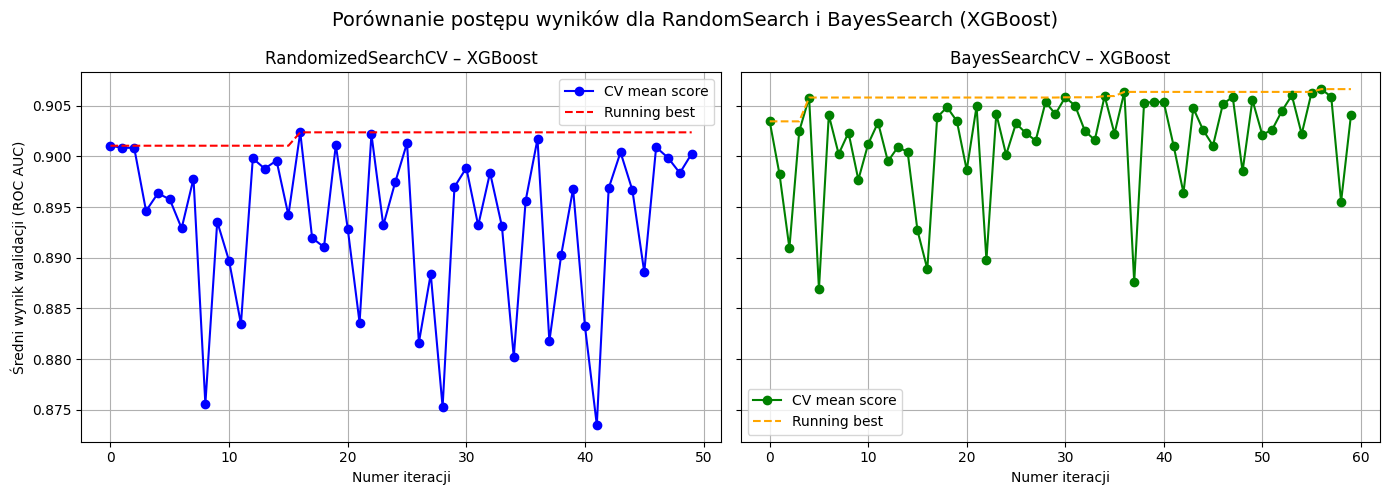

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# --- RandomizedSearchCV ---
axes[0].plot(weather_random["iter"], weather_random["mean_test_score"], marker="o", label="CV mean score", color="blue")
axes[0].plot(weather_random["iter"], weather_random["running_best"], color="red", linestyle="--", label="Running best")
axes[0].set_title("RandomizedSearchCV – XGBoost")
axes[0].set_xlabel("Numer iteracji")
axes[0].set_ylabel("Średni wynik walidacji (ROC AUC)")
axes[0].grid(True)
axes[0].legend()

# --- BayesSearchCV ---
axes[1].plot(weather_bayes["iter"], weather_bayes["mean_test_score"], marker="o", label="CV mean score", color="green")
axes[1].plot(weather_bayes["iter"], weather_bayes["running_best"], color="orange", linestyle="--", label="Running best")
axes[1].set_title("BayesSearchCV – XGBoost")
axes[1].set_xlabel("Numer iteracji")
axes[1].grid(True)
axes[1].legend()

plt.suptitle("Porównanie postępu wyników dla RandomSearch i BayesSearch (XGBoost)", fontsize=14)
plt.tight_layout()
plt.show()
